In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, classification_report, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve

In [3]:
np.random.seed(44)

In [4]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

In [5]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Missing values** <br>
Train: Age, Cabin, Embarked <br>
Test: Age, Fare, Cabin

In [7]:
trainPassengerId = train['PassengerId']
testPassengerId = test['PassengerId']

data = pd.concat([train, test]).reset_index(drop=True)
data.drop('PassengerId', axis=1, inplace=True)

In [8]:
data.sample(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
47,1.0,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.75,NaN,Q
41,0.0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.00,NaN,S
760,0.0,3,"Garfirth, Mr. John",male,NaN,0,0,358585,14.50,NaN,S


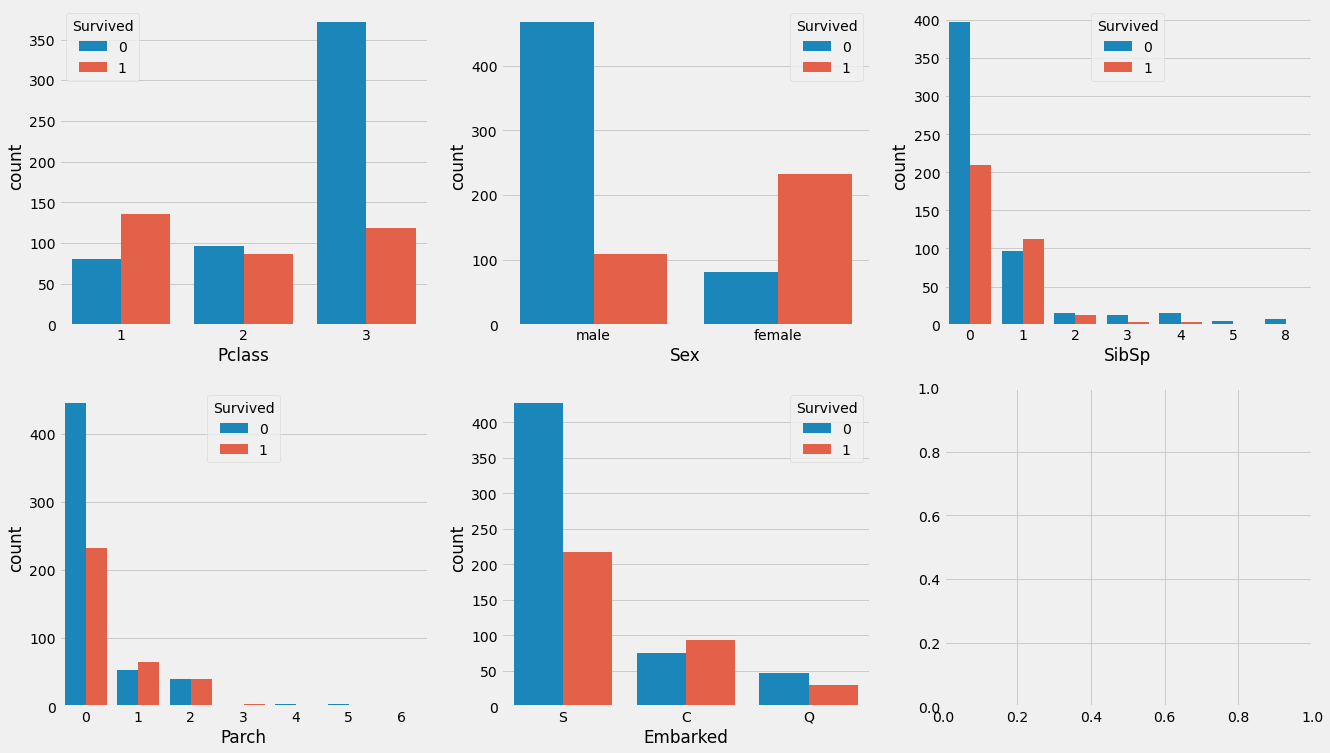

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(20,12))
cat_features = ['Pclass','Sex','SibSp','Parch','Embarked']
for i in range(len(cat_features)):
    sns.countplot(data=train, x=cat_features[i], hue='Survived', ax=ax[i//3][i%3])

In [10]:
data.corr()['Age'].sort_values(ascending=False)

Age         1.000000
Fare        0.178740
Survived   -0.077221
Parch      -0.150917
SibSp      -0.243699
Pclass     -0.408106
Name: Age, dtype: float64

In [11]:
imputeage = data.groupby(['Pclass','Sex']).median()
for pclass, sex in imputeage.index:
    median_age = imputeage.loc[(pclass,sex)]['Age']
    data.loc[(data['Age'].isnull()) & (data['Pclass']==pclass) & (data['Sex']==sex), 'Age'] = median_age

In [12]:
print(data['Embarked'].value_counts())
data['Embarked'] = data['Embarked'].fillna('S')

S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [13]:
print(data.corr()['Fare'].sort_values(ascending=False))
data[data['Fare'].isnull()]

Fare        1.000000
Survived    0.257307
Parch       0.221539
Age         0.200039
SibSp       0.160238
Pclass     -0.558629
Name: Fare, dtype: float64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [14]:
pc3median_fare = data[data['Pclass']==3]['Fare'].median()
data['Fare'] = data['Fare'].fillna(pc3median_fare)

In [15]:
data['Deck'] = data['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'X')
deckgroup = data[:891].groupby('Deck')[['Survived','Pclass']].mean()

<AxesSubplot:xlabel='Deck', ylabel='Pclass'>

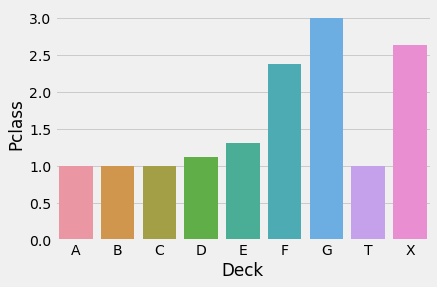

In [16]:
sns.barplot(data=deckgroup, x=deckgroup.index, y=deckgroup['Pclass'])

In [17]:
data['Deck'] = data['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
data['Deck'] = data['Deck'].replace(['D', 'E'], 'DE')
data['Deck'] = data['Deck'].replace(['F', 'G'], 'FG')
data['Deck'].value_counts()

X      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [18]:
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'the Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data['title'] = [i.split(",")[1].split(".")[0].strip() for i in data['Name']]
data.replace({'title': mapping}, inplace=True)
data['title'].value_counts()

Mr        767
Miss      265
Mrs       200
Master     61
Rev         8
Dr          8
Name: title, dtype: int64

<AxesSubplot:xlabel='title', ylabel='Survived'>

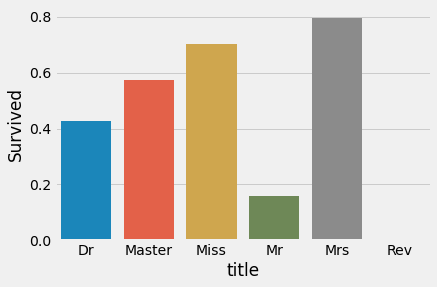

In [19]:
title_sur = data[:891].groupby('title').mean()
sns.barplot(data=title_sur, x=title_sur.index, y=title_sur['Survived'])

In [20]:
data['Surname'] = data['Name'].str.split(',').str.get(0)

In [21]:
for i in data['Surname'].iteritems():
    # English
    if i[1].endswith('ley') or i[1].endswith("ers") or i[1].endswith("en") or i[1].endswith("ton") or i[1].endswith("ing") or i[1].endswith("ings"):
        data.loc[i[0],'Ethnicity'] = 'English'
    # Irish
    if i[1].startswith('Mc') or i[1].startswith("O'") or i[1].startswith("Fitz") or i[1].endswith("ty"):
        data.loc[i[0],'Ethnicity'] = 'Irish'
    # Scandinavian
    if i[1].endswith('son') or i[1].endswith('sen') or i[1].endswith('la') or i[1].endswith('lä') or i[1].endswith('nen'):
        data.loc[i[0],'Ethnicity'] = 'Scandinavian'
    # Scottish
    if i[1].startswith('Mac') or i[1].startswith('Mag'):
        data.loc[i[0],'Ethnicity'] = 'Scottish'
    # EasterEuropean
    if i[1].endswith('ski') or i[1].endswith('vic') or i[1].endswith('off') or i[1].endswith('cki') or i[1].endswith('dzki') or i[1].endswith('wicz') or i[1].endswith('czyk') or i[1].endswith('czak') or i[1].endswith('czek') or i[1].endswith('ek') or i[1].endswith('ak') or i[1].endswith('vić') or i[1].endswith('ov') or i[1].endswith('yev') or i[1].endswith('enko') or i[1].endswith('shin'):
        data.loc[i[0],'Ethnicity'] = 'EasternEuropean'
    # SouthernEuropean
    if i[1].startswith('De ') or i[1].startswith('Di ') or i[1].startswith('D ') or i[1].endswith('as') or i[1].endswith('is') or i[1].endswith('us') or i[1].endswith('es') or i[1].endswith('ez') or i[1].endswith('akis') or i[1].endswith('idis') or i[1].endswith('opoulos') or i[1].endswith('ni') or i[1].endswith('no') or i[1].endswith('zzi') or i[1].endswith('tti') or i[1].endswith('ero') or i[1].endswith('eri') or i[1].endswith('elli') or i[1].endswith('er') or i[1].endswith('ossi') or i[1].endswith('aldi'):
        data.loc[i[0],'Ethnicity'] = 'SouthernEuropean'
    # CentralEuropean
    if i[1].startswith('van ') or i[1].startswith('von ') or i[1].endswith('che') or i[1].endswith('elle') or i[1].endswith('er') or i[1].endswith('stein') or i[1].endswith('baum') or i[1].endswith('berg'):
        data.loc[i[0],'Ethnicity'] = 'CentralEuropean'

In [22]:
ethnic_map = {"English": 1, "Irish": 2, "Scottish": 3,
             "Scandinavian": 4, "EasternEuropean": 5,
             "SouthernEuropean": 6, "CentralEuropean": 7}

data['EthnicityScaled'] = data['Ethnicity'].map(ethnic_map)
data['EthnicityScaled'] = data['EthnicityScaled'].fillna(0)
data.EthnicityScaled = data.EthnicityScaled.astype(int)

In [23]:
data['Fare_cat'] = pd.qcut(data['Fare'], 5, labels=[0,1,2,3,4])
data['Age_cat'] = pd.cut(data['Age'],bins=[0,15,30,45,60,np.nan],labels=[0,1,2,3,4])

In [24]:
data["FamilySize"]=data["SibSp"]+data["Parch"]+1
data['Ticket_Frequency'] = data.groupby('Ticket')['Ticket'].transform('count')
data["IsAlone"] = data["FamilySize"]==1
data["IsAlone"] = data["IsAlone"].astype(int)

In [25]:
# cols = ['Age','Fare','SibSp','Parch']
# drop_outliers = list()
# for col in cols:
#     Q1 = train[col].describe()['25%']
#     Q3 = train[col].describe()['75%']
#     IQR = Q3-Q1
#     outlier_step = 1.5*IQR
#     outliersidx = train[(train[col]<Q1-outlier_step) | (train[col]>Q3+outlier_step)].index
#     drop_outliers.extend(outliersidx)

# from collections import Counter
# outlierscnt = Counter(drop_outliers)
# outliersidx = [k for k,v in outlierscnt.items() if v>2]
# outliersidx

In [26]:
# train.drop(outliersidx, axis=0, inplace=True)
# train.reset_index(drop=True)

In [27]:
data.drop(['Name','Cabin','Ticket','Fare','Age','Ethnicity','Surname'],axis=1,inplace=True)

In [28]:
data.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Deck,title,EthnicityScaled,Fare_cat,Age_cat,FamilySize,Ticket_Frequency,IsAlone
0,0.0,3,male,1,0,S,X,Mr,0,0,1,2,1,0
1,1.0,1,female,1,0,C,ABC,Mrs,1,4,2,2,2,0
2,1.0,3,female,0,0,S,X,Miss,4,1,1,1,1,1
3,1.0,1,female,1,0,S,ABC,Mrs,7,4,2,2,2,0
4,0.0,3,male,0,0,S,X,Mr,1,1,2,1,1,1


In [29]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'title']
for feature in non_numeric_features:        
        data[feature] = LabelEncoder().fit_transform(data[feature])

In [30]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'title', 'EthnicityScaled']
for feature in cat_features:
    onehot = pd.get_dummies(data[feature], prefix=feature)
    data[list(onehot.columns)] = onehot.values

In [31]:
data.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Deck,title,EthnicityScaled,Fare_cat,...,title_4,title_5,EthnicityScaled_0,EthnicityScaled_1,EthnicityScaled_2,EthnicityScaled_3,EthnicityScaled_4,EthnicityScaled_5,EthnicityScaled_6,EthnicityScaled_7
0,0.0,3,1,1,0,2,3,3,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1.0,1,0,1,0,0,0,4,1,4,...,1,0,0,1,0,0,0,0,0,0
2,1.0,3,0,0,0,2,3,2,4,1,...,0,0,0,0,0,0,1,0,0,0
3,1.0,1,0,1,0,2,0,4,7,4,...,1,0,0,0,0,0,0,0,0,1
4,0.0,3,1,0,0,2,3,3,1,1,...,0,0,0,1,0,0,0,0,0,0


In [32]:
# from sklearn.preprocessing import StandardScaler
# for data in dataset:
#     scaler = StandardScaler()
#     scaled = scaler.fit_transform(data)
#     data = scaled

In [33]:
data[['Fare_cat', 'Age_cat']] = data[['Fare_cat', 'Age_cat']].astype('int')

In [34]:
train = data[:891]
test = data[891:].iloc[:,1:]

<AxesSubplot:>

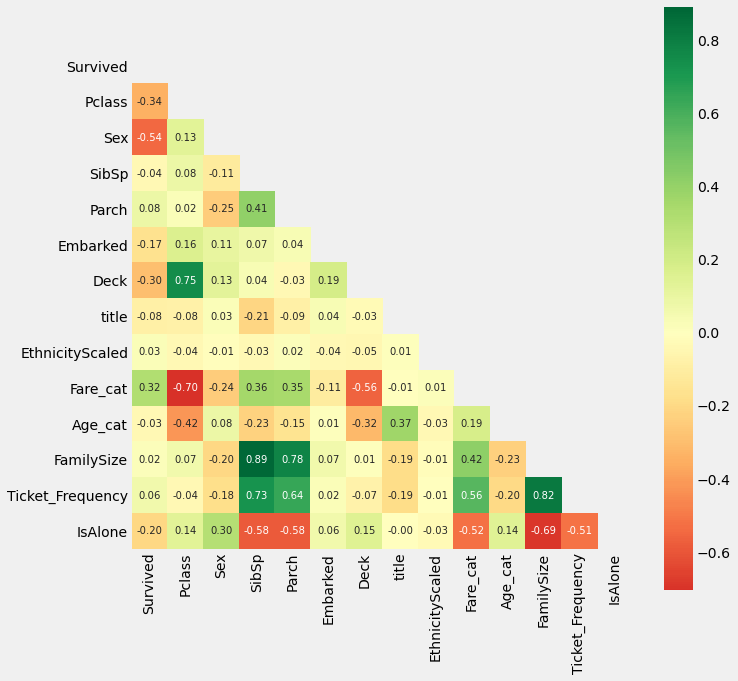

In [35]:
mat = train.iloc[:,:14].corr()[['Survived','Pclass','Sex','SibSp','Parch','Embarked','Deck','title','EthnicityScaled',
                    'Fare_cat','Age_cat','FamilySize','Ticket_Frequency','IsAlone']]
mask = np.triu(np.ones_like(mat, dtype=bool))
plt.figure(figsize=(10,10))
sns.heatmap(mat, mask=mask, center=0, annot=True, fmt='.2f', square=True, linecolor='white', cmap='RdYlGn', annot_kws={'fontsize':10})

In [36]:
kfold = StratifiedKFold(n_splits=5)
train_X = train[train.columns[1:]]
train_y = train[train.columns[:1]]

In [37]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Pclass             891 non-null    int64
 1   Sex                891 non-null    int64
 2   SibSp              891 non-null    int64
 3   Parch              891 non-null    int64
 4   Embarked           891 non-null    int64
 5   Deck               891 non-null    int64
 6   title              891 non-null    int64
 7   EthnicityScaled    891 non-null    int64
 8   Fare_cat           891 non-null    int64
 9   Age_cat            891 non-null    int64
 10  FamilySize         891 non-null    int64
 11  Ticket_Frequency   891 non-null    int64
 12  IsAlone            891 non-null    int64
 13  Pclass_1           891 non-null    int64
 14  Pclass_2           891 non-null    int64
 15  Pclass_3           891 non-null    int64
 16  Sex_0              891 non-null    int64
 17  Sex_1           

[11:39:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:39:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:39:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:39:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,accuracy,roc_auc_score
SVC,0.823793,0.845109
Decision Tree,0.799102,0.783509
Random Forest,0.817059,0.850659
Extra Trees,0.802469,0.827451
KNeighbors,0.787879,0.821568
Logisitic Regression,0.815937,0.865566
Naive Bayes,0.616162,0.835661
AdaBoost,0.812570,0.864019
GradientBoosting,0.828283,0.879433
XGBoost,0.820426,0.856826


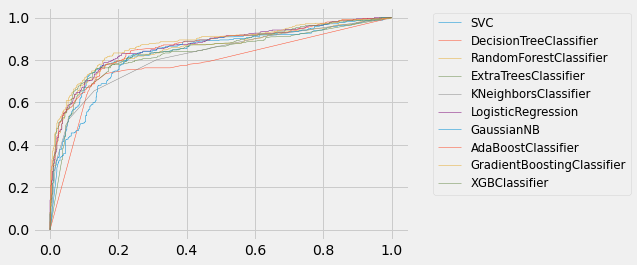

In [38]:
models = [SVC(probability=True),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          ExtraTreesClassifier(),
          KNeighborsClassifier(),
          LogisticRegression(),
          GaussianNB(),
          AdaBoostClassifier(),
          GradientBoostingClassifier(),
          XGBClassifier()]

cv_results = list()
confmats = list()
roc_auc = list()
for model in models:
    train_y_pred = cross_val_predict(model, train_X, train_y.iloc[:,0], cv=kfold, n_jobs=-1)
    y_scores = cross_val_predict(model, train_X, train_y.iloc[:,0], cv=kfold, method="predict_proba")

    confmats.append(confusion_matrix(train_y, train_y_pred))
    cv_results.append(metrics.accuracy_score(train_y_pred, train_y))
#     print(classification_report(train_y_pred, train_y))
    fpr, tpr, thresholds = roc_curve(train_y, y_scores[:,1])
    plt.plot(fpr, tpr, label=str(model).split('(')[0], linewidth=0.5)
    roc_auc.append(roc_auc_score(train_y, y_scores[:,1]))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
index = ["SVC", "Decision Tree", "Random Forest", "Extra Trees", "KNeighbors",
         "Logisitic Regression", "Naive Bayes", "AdaBoost", "GradientBoosting","XGBoost"]
result = pd.DataFrame({'accuracy':cv_results, 'roc_auc_score':roc_auc}, index=index)
result

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86       570
         1.0       0.75      0.79      0.77       321

    accuracy                           0.83       891
   macro avg       0.81      0.82      0.82       891
weighted avg       0.83      0.83      0.83       891



[]

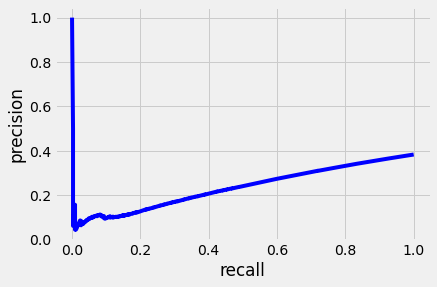

In [39]:
clf = GradientBoostingClassifier()
train_y_pred = cross_val_predict(clf, train_X, train_y.iloc[:,0], cv=kfold, n_jobs=-1)
y_scores = cross_val_predict(clf, train_X, train_y.iloc[:,0], cv=kfold, method="predict_proba")

print(classification_report(train_y_pred, train_y))
precisions, recalls, thresholds = precision_recall_curve(train_y, y_scores[:,0])
plt.plot(recalls, precisions, 'b')
plt.xlabel('recall'); plt.ylabel('precision')
plt.plot()

In [40]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_idx, test_idx in skfolds.split(train_X, train_y):
    X_train = train_X.loc[train_idx]
    y_train = train_y.loc[train_idx]
    X_test = train_X.loc[test_idx]
    y_test = train_y.loc[test_idx]

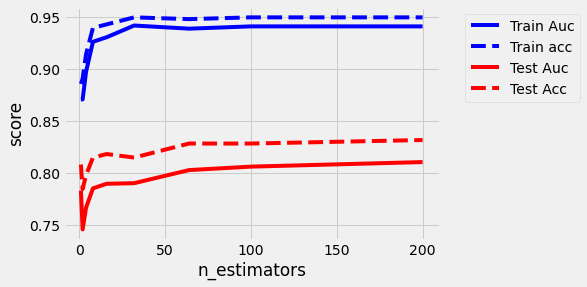

In [41]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_auc = []
train_acc = []
test_auc = []
test_acc = []
for est in n_estimators:
    model = RandomForestClassifier(n_estimators=est, random_state=0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_auc.append(roc_auc_score(y_train, train_pred))
    train_acc.append(metrics.accuracy_score(y_train, train_pred))
    test_pred = model.predict(X_test)
    test_auc.append(roc_auc_score(y_test, test_pred))
    test_acc.append(metrics.accuracy_score(y_test, test_pred))
plt.plot(n_estimators, train_auc, 'b', label="Train Auc")
plt.plot(n_estimators, train_acc, 'b--', label="Train acc")
plt.plot(n_estimators, test_auc, 'r', label="Test Auc")
plt.plot(n_estimators, test_acc, 'r--', label="Test Acc")
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

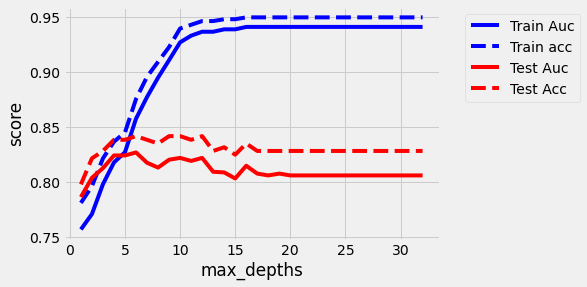

In [42]:
max_depths = list(range(1, 33))
train_auc = []
train_acc = []
test_auc = []
test_acc = []
for d in max_depths:
    model = RandomForestClassifier(max_depth=d, random_state=0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_auc.append(roc_auc_score(y_train, train_pred))
    train_acc.append(metrics.accuracy_score(y_train, train_pred))
    test_pred = model.predict(X_test)
    test_auc.append(roc_auc_score(y_test, test_pred))
    test_acc.append(metrics.accuracy_score(y_test, test_pred))
plt.plot(max_depths, train_auc, 'b', label="Train Auc")
plt.plot(max_depths, train_acc, 'b--', label="Train acc")
plt.plot(max_depths, test_auc, 'r', label="Test Auc")
plt.plot(max_depths, test_acc, 'r--', label="Test Acc")
plt.ylabel('score')
plt.xlabel('max_depths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

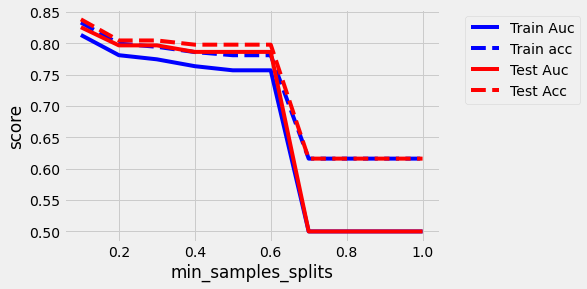

In [43]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_auc = []
train_acc = []
test_auc = []
test_acc = []
for min_samples_split in min_samples_splits:
    model = RandomForestClassifier(min_samples_split=min_samples_split, random_state=0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_auc.append(roc_auc_score(y_train, train_pred))
    train_acc.append(metrics.accuracy_score(y_train, train_pred))
    test_pred = model.predict(X_test)
    test_auc.append(roc_auc_score(y_test, test_pred))
    test_acc.append(metrics.accuracy_score(y_test, test_pred))
plt.plot(min_samples_splits, train_auc, 'b', label="Train Auc")
plt.plot(min_samples_splits, train_acc, 'b--', label="Train acc")
plt.plot(min_samples_splits, test_auc, 'r', label="Test Auc")
plt.plot(min_samples_splits, test_acc, 'r--', label="Test Acc")
plt.ylabel('score')
plt.xlabel('min_samples_splits')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

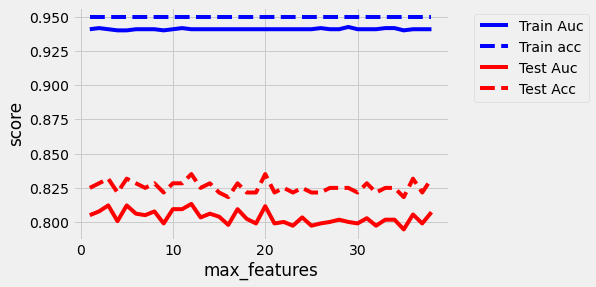

In [44]:
max_features = list(range(1,X_train.shape[1]))
train_auc = []
train_acc = []
test_auc = []
test_acc = []
for max_feature in max_features:
    model = RandomForestClassifier(max_features=max_feature, random_state=0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_auc.append(roc_auc_score(y_train, train_pred))
    train_acc.append(metrics.accuracy_score(y_train, train_pred))
    test_pred = model.predict(X_test)
    test_auc.append(roc_auc_score(y_test, test_pred))
    test_acc.append(metrics.accuracy_score(y_test, test_pred))
plt.plot(max_features, train_auc, 'b', label="Train Auc")
plt.plot(max_features, train_acc, 'b--', label="Train acc")
plt.plot(max_features, test_auc, 'r', label="Test Auc")
plt.plot(max_features, test_acc, 'r--', label="Test Acc")
plt.ylabel('score')
plt.xlabel('max_features')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

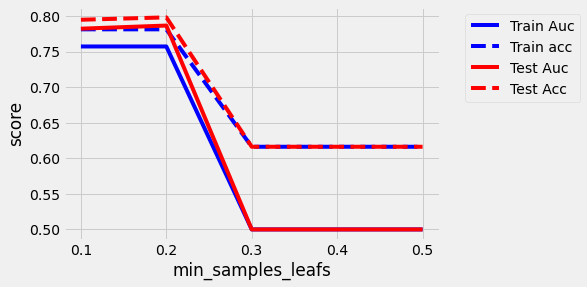

In [45]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_auc = []
train_acc = []
test_auc = []
test_acc = []
for min_samples_leaf in min_samples_leafs:
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_auc.append(roc_auc_score(y_train, train_pred))
    train_acc.append(metrics.accuracy_score(y_train, train_pred))
    test_pred = model.predict(X_test)
    test_auc.append(roc_auc_score(y_test, test_pred))
    test_acc.append(metrics.accuracy_score(y_test, test_pred))
plt.plot(min_samples_leafs, train_auc, 'b', label="Train Auc")
plt.plot(min_samples_leafs, train_acc, 'b--', label="Train acc")
plt.plot(min_samples_leafs, test_auc, 'r', label="Test Auc")
plt.plot(min_samples_leafs, test_acc, 'r--', label="Test Acc")
plt.ylabel('score')
plt.xlabel('min_samples_leafs')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

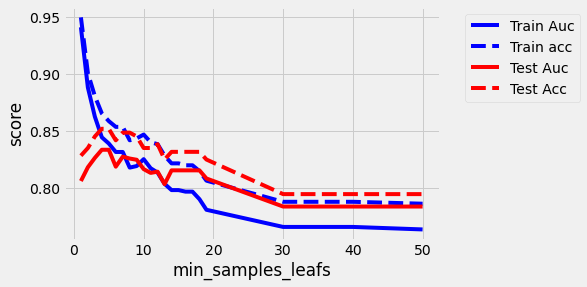

In [46]:
min_samples_leafs = list(range(1,20))+[30,40,50]
train_auc = []
train_acc = []
test_auc = []
test_acc = []
for min_samples_leaf in min_samples_leafs:
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_auc.append(roc_auc_score(y_train, train_pred))
    train_acc.append(metrics.accuracy_score(y_train, train_pred))
    test_pred = model.predict(X_test)
    test_auc.append(roc_auc_score(y_test, test_pred))
    test_acc.append(metrics.accuracy_score(y_test, test_pred))
plt.plot(min_samples_leafs, train_auc, 'b', label="Train Auc")
plt.plot(min_samples_leafs, train_acc, 'b--', label="Train acc")
plt.plot(min_samples_leafs, test_auc, 'r', label="Test Auc")
plt.plot(min_samples_leafs, test_acc, 'r--', label="Test Acc")
plt.ylabel('score')
plt.xlabel('min_samples_leafs')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [47]:
model = RandomForestClassifier(n_estimators=33, max_depth=9, min_samples_leaf=3, random_state=0)
model.fit(train_X, train_y)

RandomForestClassifier(max_depth=9, min_samples_leaf=3, n_estimators=33,
                       random_state=0)

Text(0.5, 1.0, 'Random Forest feature importances')

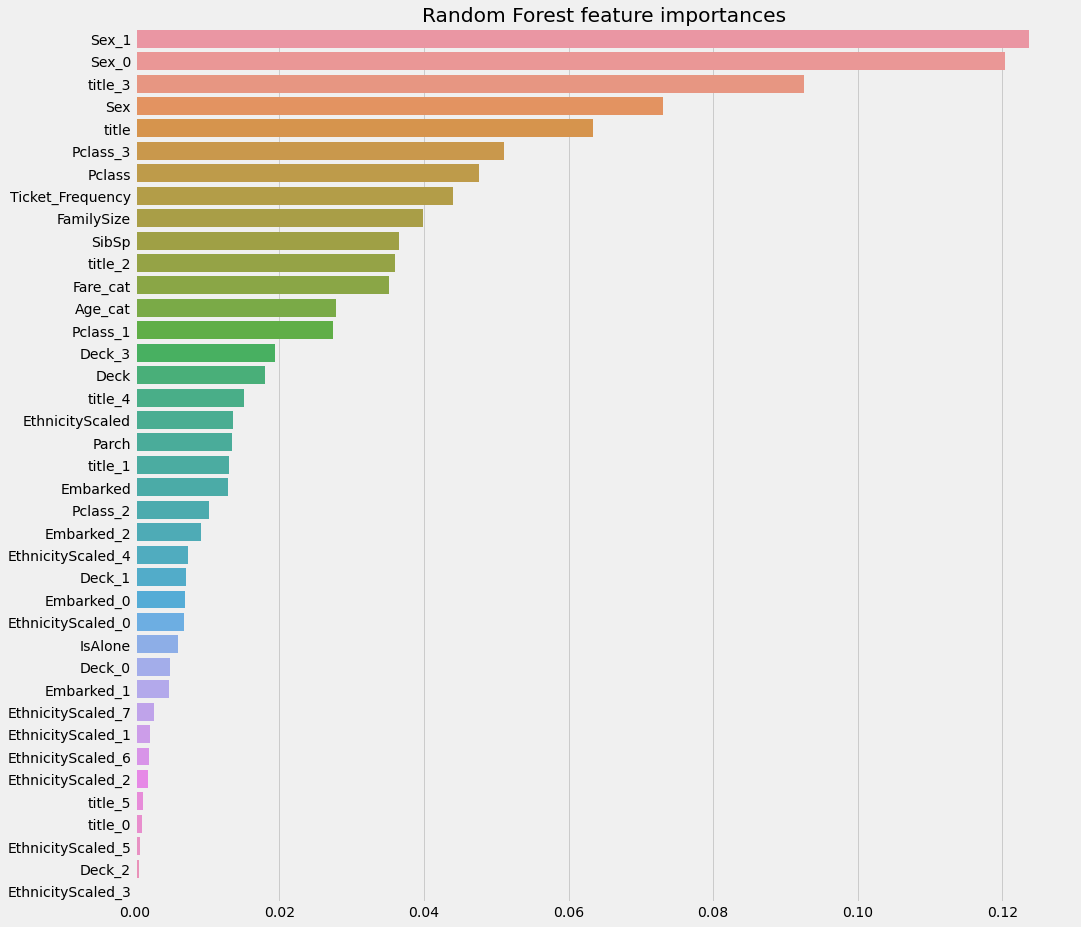

In [48]:
indices = np.argsort(model.feature_importances_)[::-1]
f, ax = plt.subplots(1,1,figsize=(15,15))
g = sns.barplot(y=train_X.columns[indices],x = model.feature_importances_[indices] ,orient='h')
g.set_title('Random Forest feature importances')

In [49]:
test.head()

,Pclass,Sex,SibSp,Parch,Embarked,Deck,title,EthnicityScaled,Fare_cat,Age_cat,...,title_4,title_5,EthnicityScaled_0,EthnicityScaled_1,EthnicityScaled_2,EthnicityScaled_3,EthnicityScaled_4,EthnicityScaled_5,EthnicityScaled_6,EthnicityScaled_7
891,3,1,0,0,1,3,3,0,0,2,...,0,0,1,0,0,0,0,0,0,0
892,3,0,1,0,2,3,4,6,0,3,...,1,0,0,0,0,0,0,0,1,0
893,2,1,0,0,1,3,3,6,1,4,...,0,0,0,0,0,0,0,0,1,0
894,3,1,0,0,2,3,3,0,1,1,...,0,0,1,0,0,0,0,0,0,0
895,3,0,1,1,2,3,4,4,2,1,...,1,0,0,0,0,0,1,0,0,0


In [50]:
labels = model.predict(test)
labels = labels.astype(int)
result = pd.concat([testPassengerId, pd.Series(labels, name="Survived")],axis=1)

In [51]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [52]:
gender = pd.read_csv("../input/titanic/gender_submission.csv")
sum(result['Survived'] == gender['Survived']) / len(result)

0.8827751196172249

In [53]:
result.to_csv("titanic_auc.csv", index=False)